In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math

from IPython import display

import os
import time
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader


np.random.seed(11)

num_neuro_1 = 10
num_neuro_2 = 10
num_neuro_3 = 5

RES_DIR = './results/'
DATA_DIR = './CCPP/'
HOME_DIR = './'
use_gpu = False

In [2]:
def visual_dispersion_hists(X_data, save_dir):
    cols = X_data.columns.get_values().tolist()
    sns_plot = sns.pairplot(X_data[cols])
    sns_plot.savefig(save_dir+'dispersion_diags.png')
#для интересующи можно будет сделать sns -> joint plot

def visual_box_n_whisker (X_data, save_dir, by_one):
    if by_one:
        fig = plt.figure(figsize=(20, 15))
        num_plot = 331
        for feat in X_data.columns:
            plt.subplot(num_plot)  
            X_data[feat].plot(kind='box')
            num_plot += 1
        fig.savefig(save_dir+'box_n_whisker_byfeat.png')
    else:
        X_data.plot(kind='box', figsize=(16, 10))
        plt.savefig(save_dir+'box_n_whisker_all.png')
        
def visual_feat_distribution(X_data, save_dir):
    fig = plt.figure(figsize=(20, 15))

    cols = X_data.columns.get_values().tolist()
    num_plot = 331
    #fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
    for idx, feat in  enumerate(cols):
        plt.subplot(num_plot)  
        plt.axes = sns.distplot(X_data[feat])
        num_plot += 1
    fig.savefig(save_dir+'feats_distrib.png')
    
def general_visual(X_data, save_dir, corr=False):
    visual_dispersion_hists(X_data, save_dir)

    visual_box_n_whisker(X_data, save_dir, by_one=False)
    visual_box_n_whisker(X_data, save_dir, by_one=True)

    visual_feat_distribution(X_data, save_dir)
    
    if corr:
        fig = plt.figure(figsize=(15, 15))
        corr_matrix = X_data.corr()
        print(corr_matrix)
        sns.heatmap(corr_matrix)
        fig.savefig(save_dir+'corr_matrix.png')

In [3]:
from sklearn.ensemble import ExtraTreesRegressor
def get_etr(X_data):
    print(X_data.head(), "\n")

    array = X_data[['AT', 'V', 'AP', 'RH', 'PE']].values

    X = array[:,0:4]
    print(X[0:5])
    Y = array[:,4]
    print(Y[0:5], "\n")

    # feature extraction

    model = ExtraTreesRegressor(max_features=3)
    model.fit(X, Y)

    print("РЕЗУЛЬТАТЫ:\n", ['AT', 'V', 'AP', 'RH'], "\n", model.feature_importances_)
    

from sklearn.preprocessing import StandardScaler, MinMaxScaler  
from scipy.stats import shapiro
def scaling(X_data, ttype, feat_list=['AT', 'V', 'AP', 'RH', 'PE'], name='_', a=True):
    #for feat in X_data.columns:
    #    print(feat+":\n", shapiro(X_data[feat].values.reshape(-1, 1)))
    #    print(shapiro(StandardScaler().fit_transform(X_data[feat].values.reshape(-1, 1))))
    # ВЫВОД: НИ ОДНО РАСПРЕДЕЛЕНИЕ, НИ ЕГО ПРЕОБРАЗОВАНИЕ НЕ ЯВЛ.НОРМАЛЬНЫМ
    if ttype=='standart':
        X_data[feat_list] = StandardScaler().fit_transform(X_data[feat_list])
        
    if ttype=='minmax':
        X_data[feat_list] = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_data[feat_list])
    
    print(X_data.describe())

    if a:
        general_visual(X_data, RES_DIR+'after_scaler/'+name, corr=True)
        
    return X_data


from sklearn.decomposition import PCA
def pca_method(X_data, a=True):
    Y = list(X_data['PE'])
    pca = PCA(whiten=True)
    X_data = pca.fit_transform(X=X_data[[feat for feat in X_data.columns[0:4]]])
    dict1 = {'AT': list(X_data[:, 0]), 'V': list(X_data[:, 1]),
             'AP': list(X_data[:, 2]), 'RH': list(X_data[:, 3]),
            'PE': Y}
    X_data = pd.DataFrame(dict1)
    print(X_data.info())

    if a:
        general_visual(X_data, RES_DIR+'after_pca1/'+'after_', corr=True)
        general_visual(X_data[['AT', 'V', 'AP', 'RH']], RES_DIR+'after_pca1/'+'after_2_', corr=True)
        
    return X_data

In [5]:
X_data = pd.read_excel(DATA_DIR+'Folds5x2_pp.xlsx', sep = ',')
print(X_data.info())
print(X_data.describe(include='all'))

a = False
if a:
    general_visual(X_data, RES_DIR+'init/', corr=True)

print('='*15)
# ОЧИСТКА ДАННЫХ
print(X_data.info())
# обнаружение, устранение дубликатов
X_data=X_data.drop_duplicates(keep='first')
print(X_data.info())

# -ii-ii- выбросов
# давление > 100 О_О
X_data=X_data[X_data['RH'] <= 100]
# выбросы - по эвристике
for feat in X_data.columns:
    q1 = X_data[feat].quantile(0.25)
    q3 = X_data[feat].quantile(0.75)
    iqr = q3-q1
    X_data=X_data[X_data[feat] < q3+1.5*iqr]
    X_data=X_data[X_data[feat] > q1-1.5*iqr]
print(X_data.info())

# пропущенные значения
#X_data=X_data.dropna()
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='median', axis=0, copy=False)
imp.fit(X_data)
X_data = imp.transform(X_data)
dict1 = {'AT': list(X_data[:, 0]), 'V': list(X_data[:, 1]),
         'AP': list(X_data[:, 2]), 'RH': list(X_data[:, 3]), 
         'PE': list(X_data[:, 4])}
X_data = pd.DataFrame(dict1)
print(X_data.info())

if a:
    general_visual(X_data, RES_DIR+'after_clean/')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
AT    9568 non-null float64
V     9568 non-null float64
AP    9568 non-null float64
RH    9568 non-null float64
PE    9568 non-null float64
dtypes: float64(5)
memory usage: 373.8 KB
None
                AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to

In [6]:
print(X_data.describe())
get_etr(X_data)

                AP           AT           PE           RH            V
count  9372.000000  9372.000000  9372.000000  9372.000000  9372.000000
mean   1013.153092    19.752302   454.155310    73.185447    54.446453
std       5.701450     7.431306    17.037068    14.461444    12.694807
min     997.340000     1.810000   420.260000    30.990000    25.360000
25%    1009.090000    13.617500   439.650000    63.237500    41.755000
50%    1012.900000    20.570000   451.085000    74.885000    52.840000
75%    1017.140000    25.780000   468.140000    84.680000    66.540000
max    1029.410000    37.110000   495.760000   100.000000    81.560000
        AP     AT      PE     RH      V
0  1024.07  14.96  463.26  73.17  41.76
1  1020.04  25.18  444.37  59.08  62.96
2  1012.16   5.11  488.56  92.14  39.40
3  1010.24  20.86  446.48  76.64  57.32
4  1009.23  10.82  473.90  96.62  37.50 

[[  14.96   41.76 1024.07   73.17]
 [  25.18   62.96 1020.04   59.08]
 [   5.11   39.4  1012.16   92.14]
 [  20.86   57

In [52]:
from sklearn.feature_selection import f_regression, mutual_info_regression
feat_list = ['AT', 'V', 'AP', 'RH']

print('f_regression:')
f_test, p_val = f_regression(X_data[feat_list], X_data['PE'])
print(f_test, "\n", p_val)
print('mutual_info_regr:')
mutual_info_regression(X_data[feat_list], X_data['PE'])

f_regression:
[82448.9402414  28997.35227538  3552.02187431  1701.964583  ] 
 [0. 0. 0. 0.]
mutual_info_regr:


array([1.15799867, 0.93746094, 0.27347441, 0.10691604])

-----------------------------------------------------

In [53]:
from sklearn.model_selection import train_test_split# деление на обуч., вал. и тест.
X, X_test = train_test_split(X_data, test_size=0.1, random_state=21)

print(X_data.shape, X.shape, X_test.shape)

(9372, 5) (8434, 5) (938, 5)


In [7]:
X_data.head()

,AP,AT,PE,RH,V
0,1024.07,14.96,463.26,73.17,41.76
1,1020.04,25.18,444.37,59.08,62.96
2,1012.16,5.11,488.56,92.14,39.40
3,1010.24,20.86,446.48,76.64,57.32
4,1009.23,10.82,473.90,96.62,37.50


                 AP            AT           PE            RH             V
count  9.372000e+03  9.372000e+03  9372.000000  9.372000e+03  9.372000e+03
mean  -1.741002e-14  3.134852e-16   454.155310  1.409635e-16 -6.717963e-16
std    1.000053e+00  1.000053e+00    17.037068  1.000053e+00  1.000053e+00
min   -2.773669e+00 -2.414550e+00   420.260000 -2.917945e+00 -2.291331e+00
25%   -7.126799e-01 -8.255789e-01   439.650000 -6.879311e-01 -9.997891e-01
50%   -4.439321e-02  1.100402e-01   451.085000  1.175293e-01 -1.265509e-01
75%    6.993169e-01  8.111657e-01   468.140000  7.948837e-01  9.526881e-01
max    2.851516e+00  2.335878e+00   495.760000  1.854309e+00  2.135912e+00
                 AP            AT           PE            RH             V
count  9.372000e+03  9.372000e+03  9372.000000  9.372000e+03  9.372000e+03
mean  -1.741002e-14  3.134852e-16     0.448945  1.409635e-16 -6.717963e-16
std    1.000053e+00  1.000053e+00     0.225657  1.000053e+00  1.000053e+00
min   -2.773669e+00 -2.41

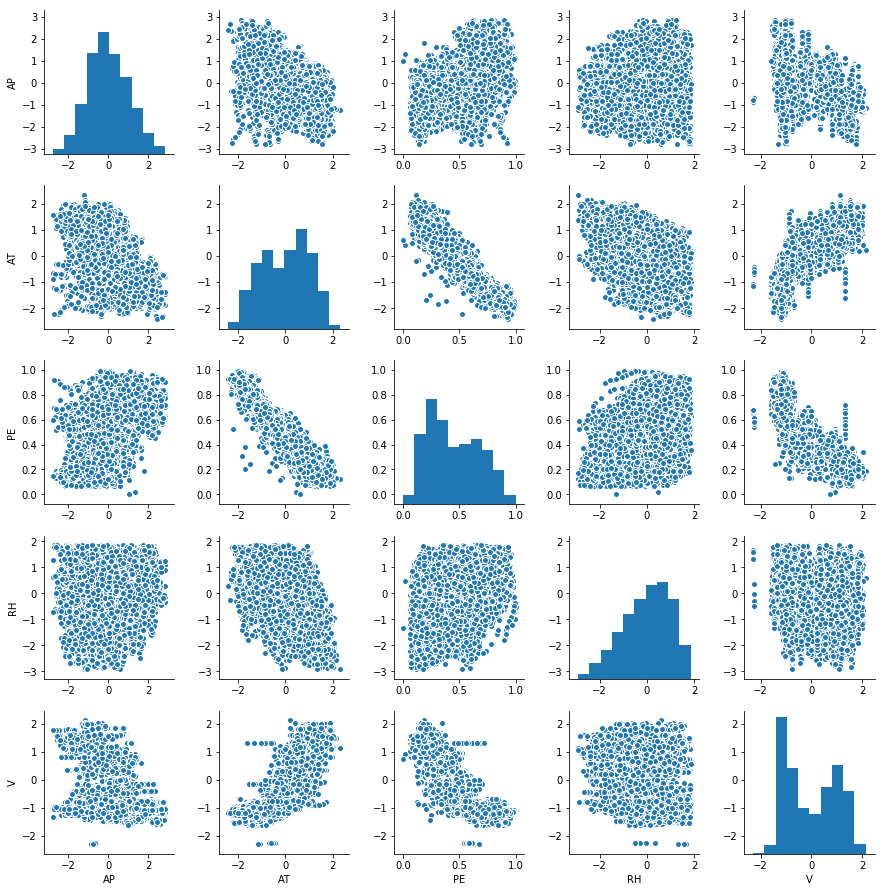

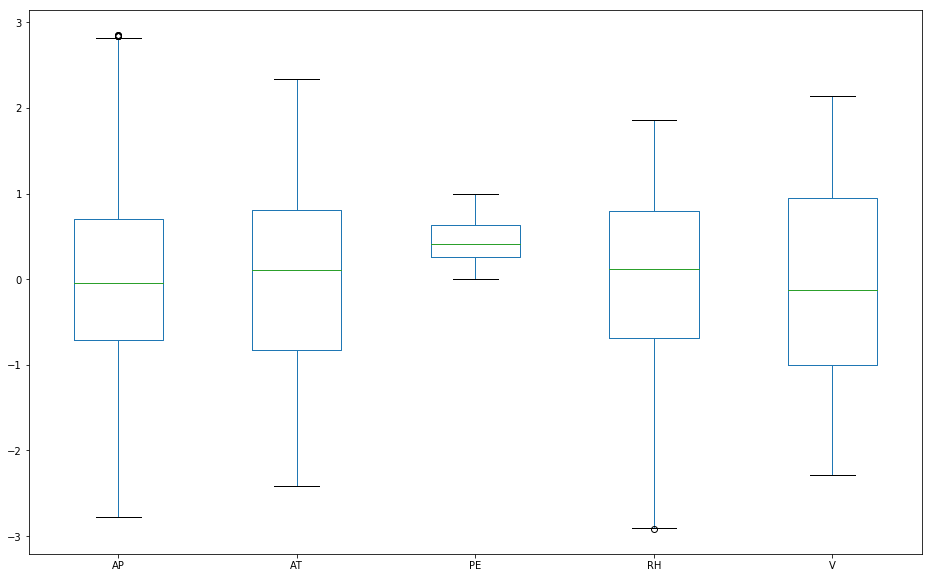

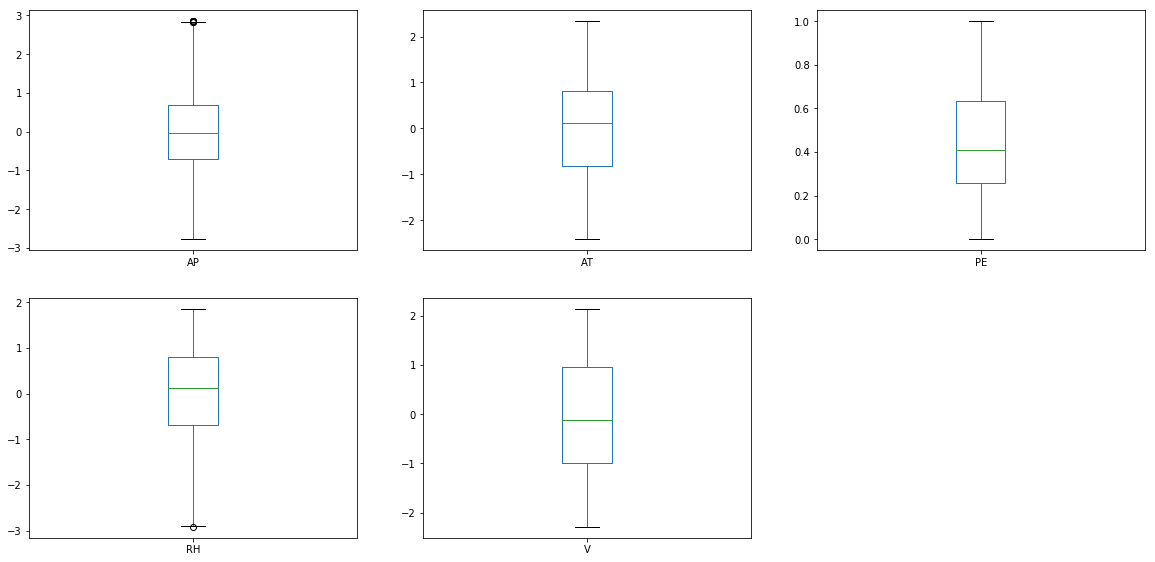

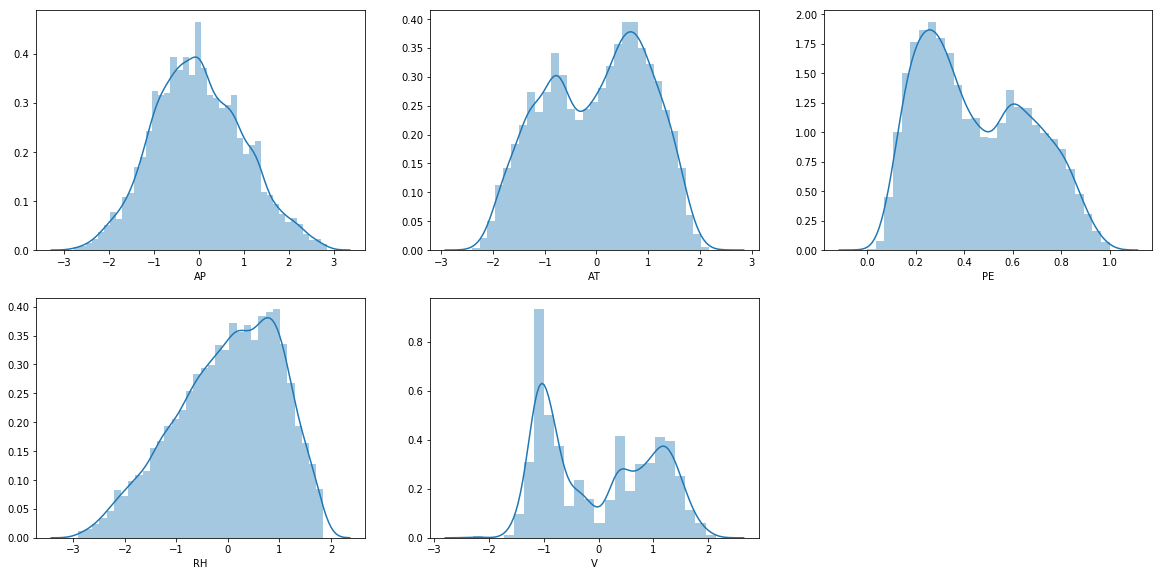

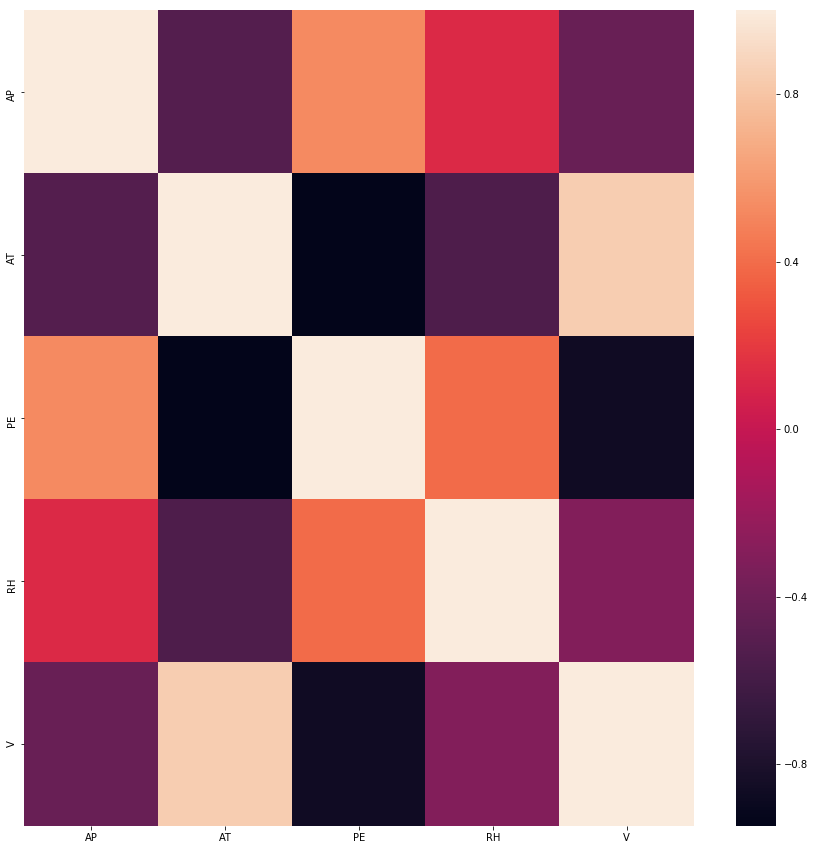

In [8]:
X = X_data
feature_list = ['AT', 'V', 'AP', 'RH']
X= scaling(X, ttype='standart', feat_list=feature_list, name='all_set', a=False)
feature_list = ['PE']
X= scaling(X, ttype='minmax', feat_list=feature_list, name='all_set', a=True)


In [9]:
feat_list = ['AT', 'V', 'AP', 'RH', 'PE']
X[feat_list].to_csv(HOME_DIR+'split_data/all_set.csv', index=False)

C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Programs\Anaconda3\lib\site-packages\pandas\core\frame.py:2356: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
C:\Programs\Anaconda3\lib\site-packages\pandas\core\frame.py:2326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_array(key, value)


                 AP            AT           PE            RH             V
count  8.434000e+03  8.434000e+03  8434.000000  8.434000e+03  8.434000e+03
mean  -1.228959e-14 -5.715793e-16   454.189042 -2.576095e-16 -1.587801e-16
std    1.000059e+00  1.000059e+00    17.029229  1.000059e+00  1.000059e+00
min   -2.777127e+00 -2.408423e+00   420.260000 -2.908350e+00 -2.287529e+00
25%   -7.148917e-01 -8.247943e-01   439.660000 -6.872858e-01 -9.978312e-01
50%   -4.910308e-02  1.028223e-01   451.340000  1.237762e-01 -1.309461e-01
75%    7.012788e-01  8.132228e-01   468.140000  7.951485e-01  9.548254e-01
max    2.845478e+00  2.332056e+00   495.760000  1.852133e+00  2.137442e+00
          AP        AT        PE        RH         V
AP  1.000000 -0.518973  0.526422  0.126897 -0.423854
AT -0.518973  1.000000 -0.947602 -0.547432  0.843132
PE  0.526422 -0.947602  1.000000  0.394963 -0.869439
RH  0.126897 -0.547432  0.394963  1.000000 -0.311216
V  -0.423854  0.843132 -0.869439 -0.311216  1.000000
       

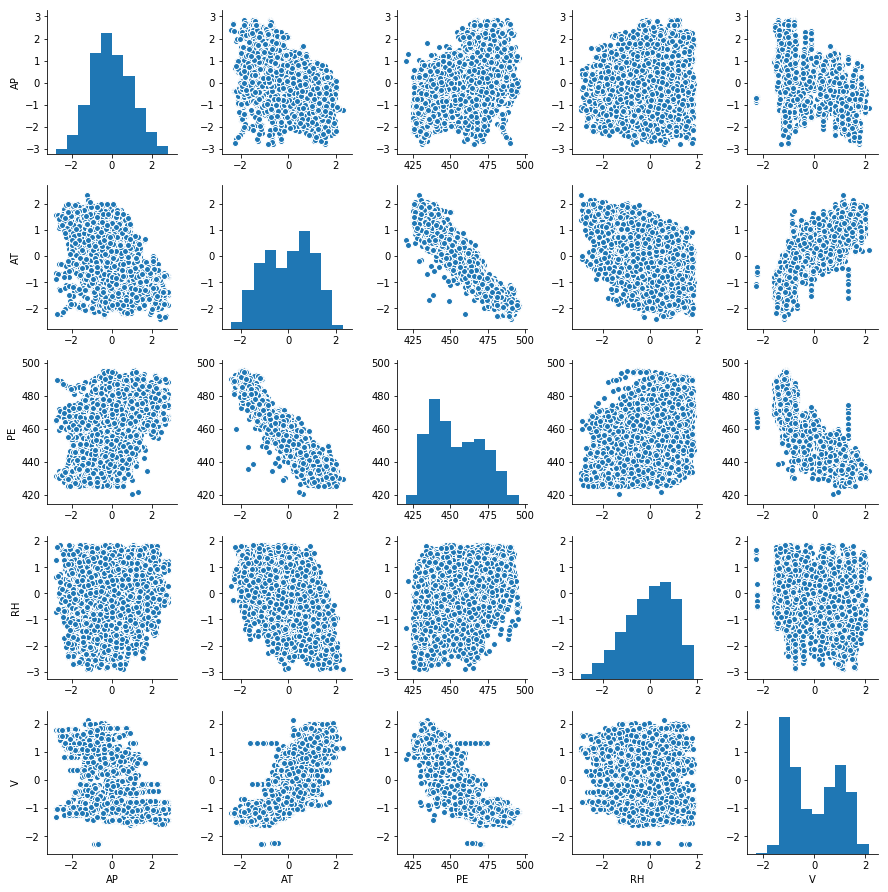

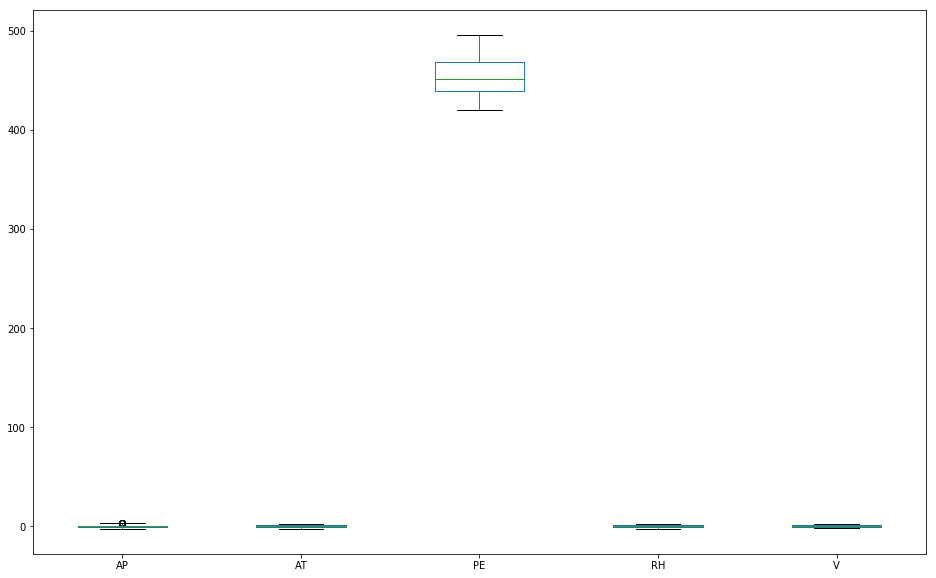

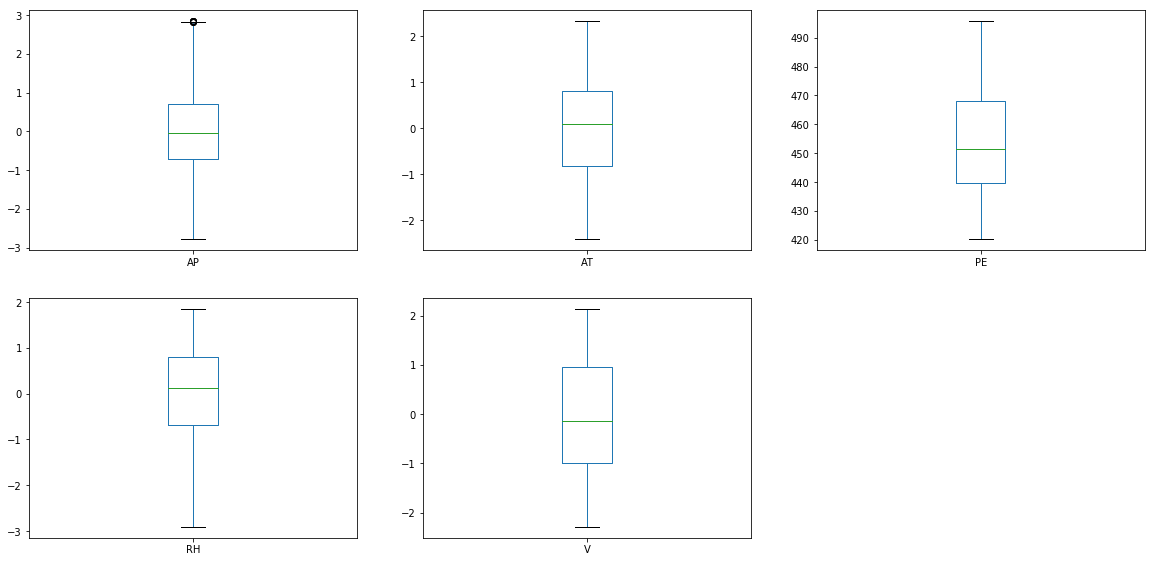

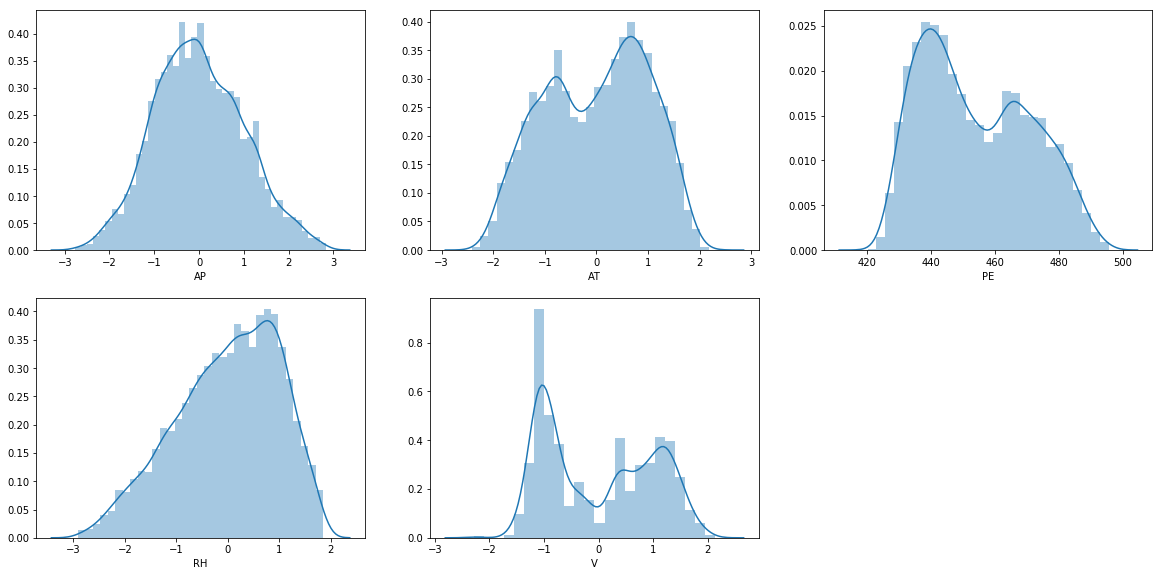

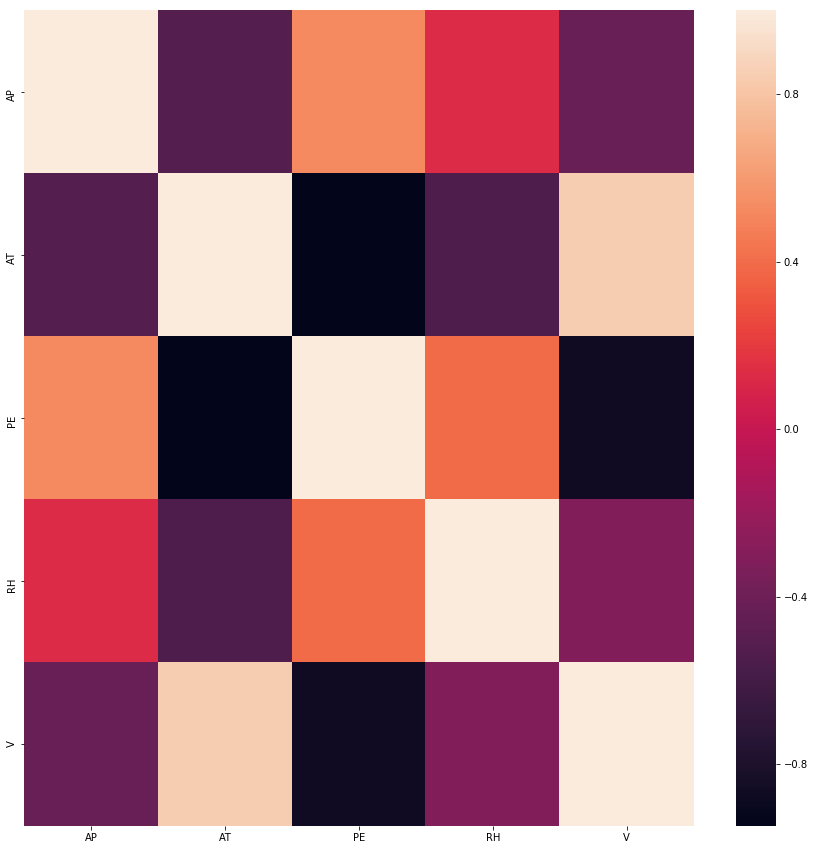

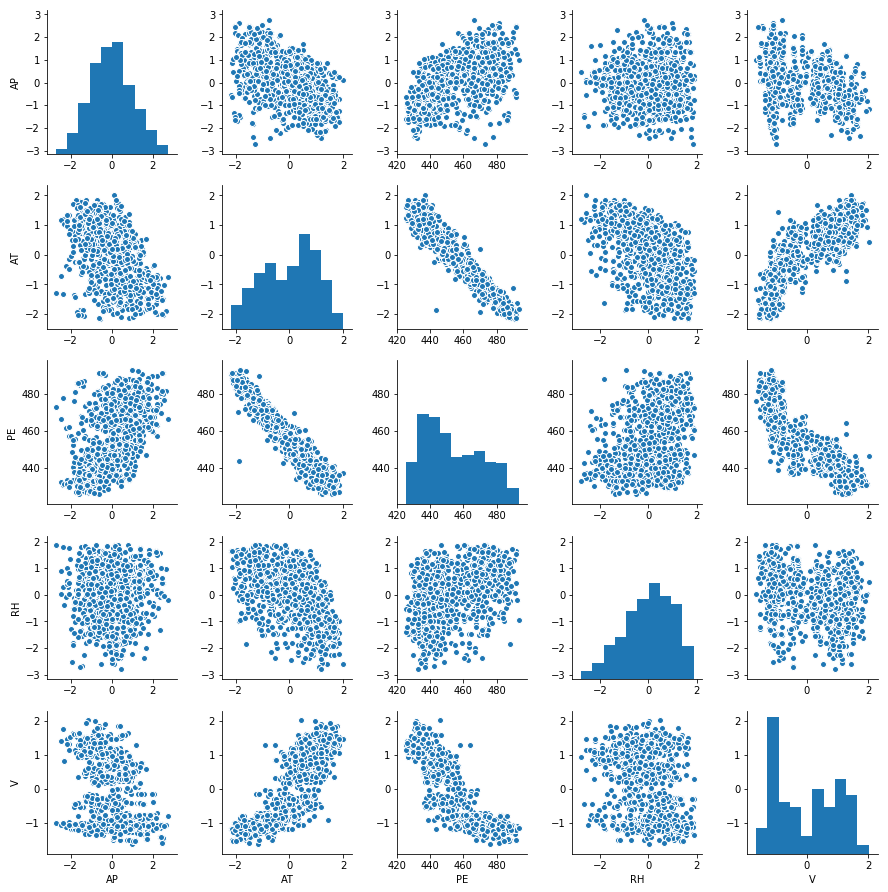

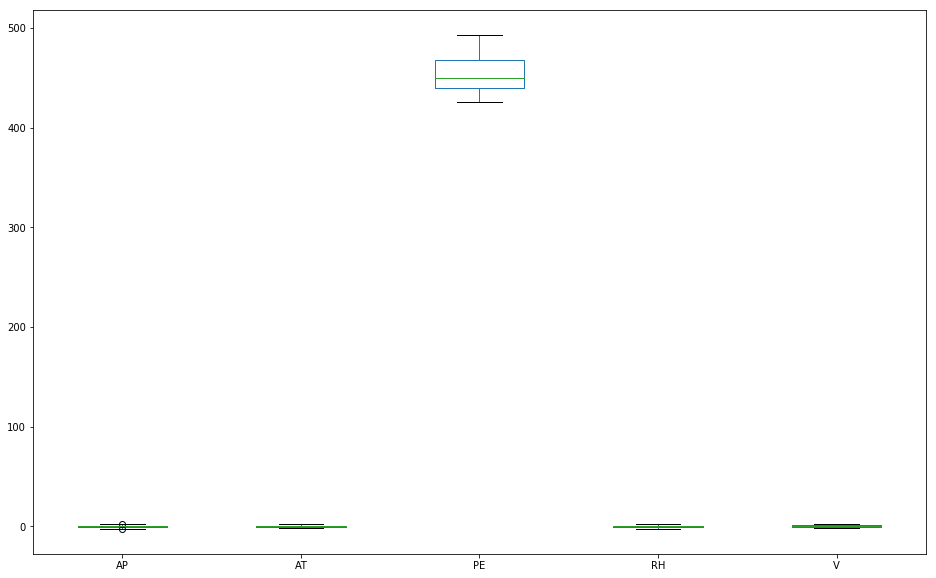

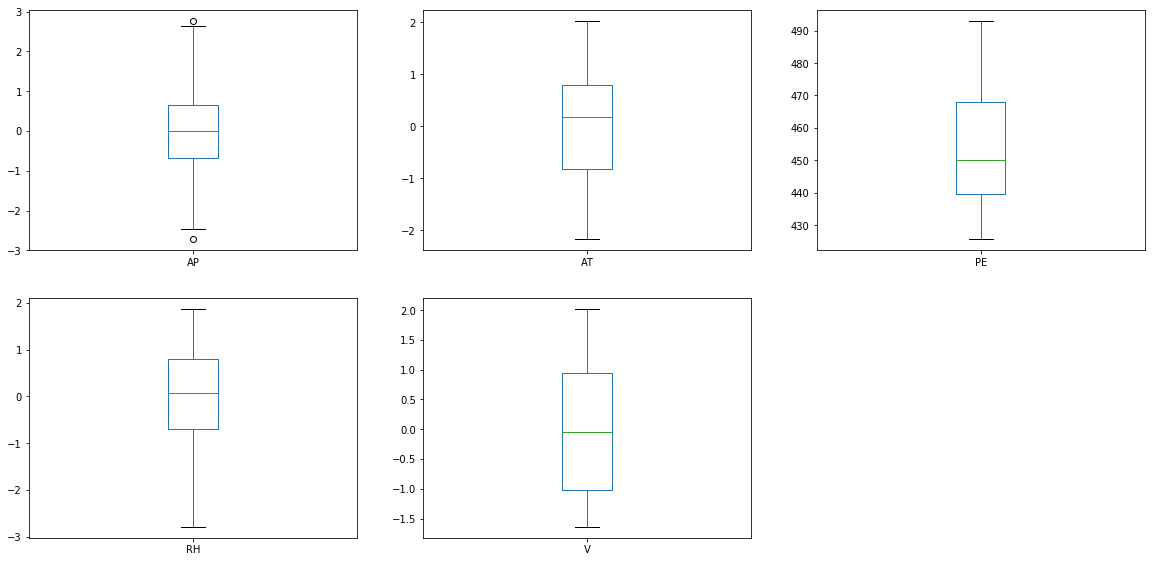

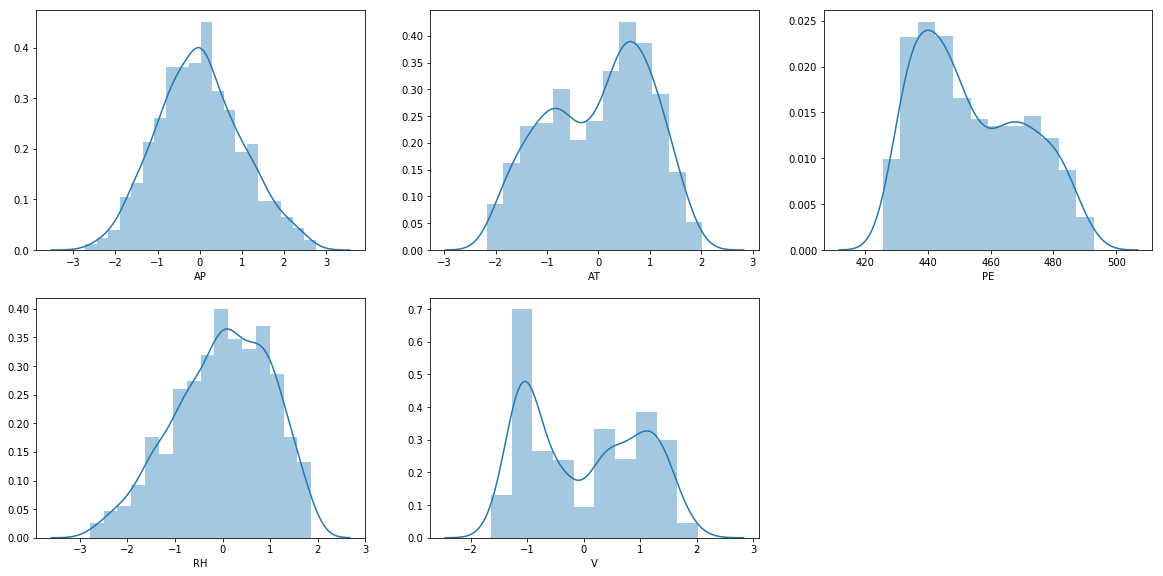

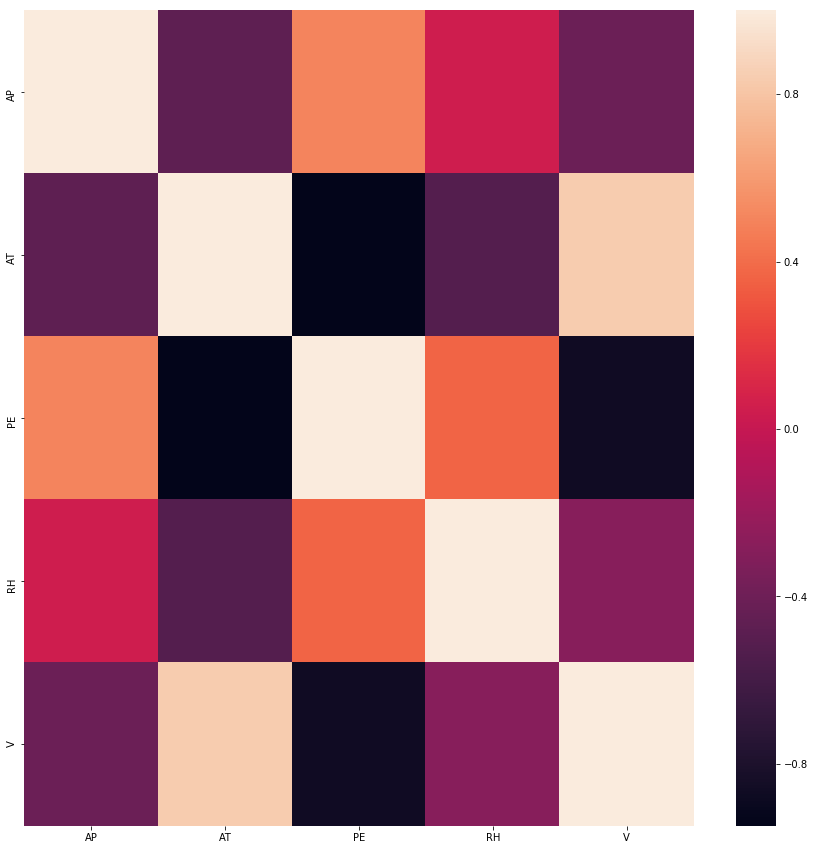

In [55]:
# входы
feature_list = ['AT', 'V', 'AP', 'RH']
X= scaling(X, ttype='standart', feat_list=feature_list, name='new_train', a=True)
X_test = scaling(X_test, ttype='standart', feat_list=feature_list, name='new_test', a=True)

C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Programs\Anaconda3\lib\site-packages\pandas\core\frame.py:2356: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
C:\Programs\Anaconda3\lib\site-packages\pandas\core\frame.py:2326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_array(key, value)


                 AP            AT           PE            RH             V
count  8.434000e+03  8.434000e+03  8434.000000  8.434000e+03  8.434000e+03
mean  -1.228959e-14 -5.715793e-16     0.449391 -2.576095e-16 -1.587801e-16
std    1.000059e+00  1.000059e+00     0.225553  1.000059e+00  1.000059e+00
min   -2.777127e+00 -2.408423e+00     0.000000 -2.908350e+00 -2.287529e+00
25%   -7.148917e-01 -8.247943e-01     0.256954 -6.872858e-01 -9.978312e-01
50%   -4.910308e-02  1.028223e-01     0.411656  1.237762e-01 -1.309461e-01
75%    7.012788e-01  8.132228e-01     0.634172  7.951485e-01  9.548254e-01
max    2.845478e+00  2.332056e+00     1.000000  1.852133e+00  2.137442e+00
          AP        AT        PE        RH         V
AP  1.000000 -0.518973  0.526422  0.126897 -0.423854
AT -0.518973  1.000000 -0.947602 -0.547432  0.843132
PE  0.526422 -0.947602  1.000000  0.394963 -0.869439
RH  0.126897 -0.547432  0.394963  1.000000 -0.311216
V  -0.423854  0.843132 -0.869439 -0.311216  1.000000
       

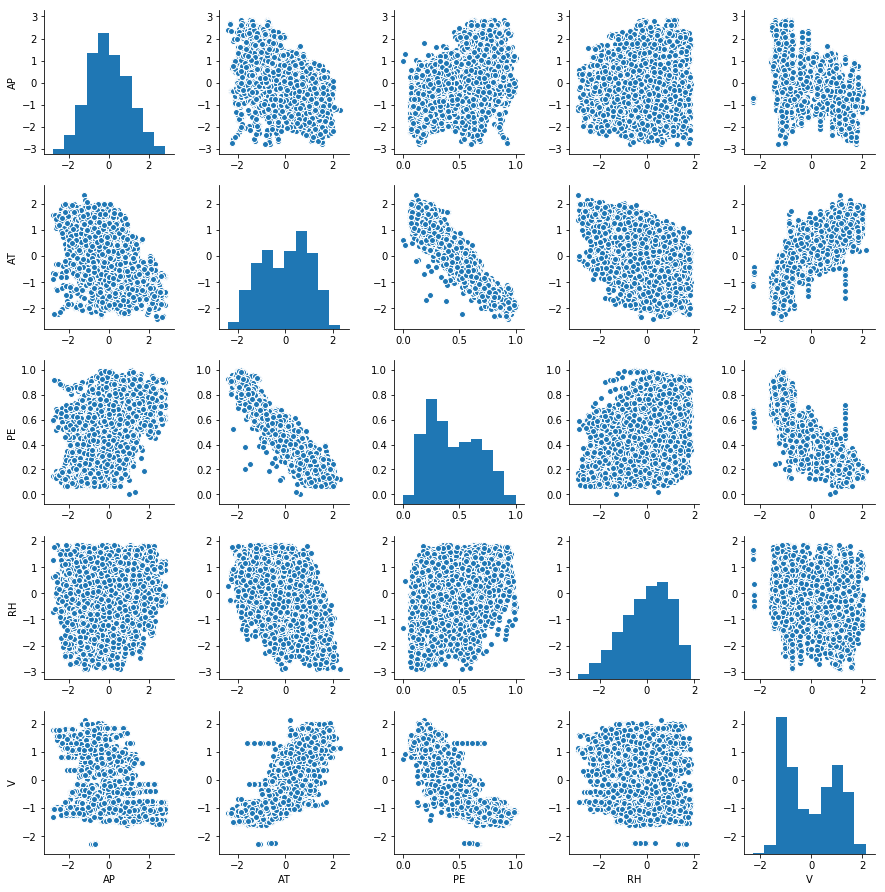

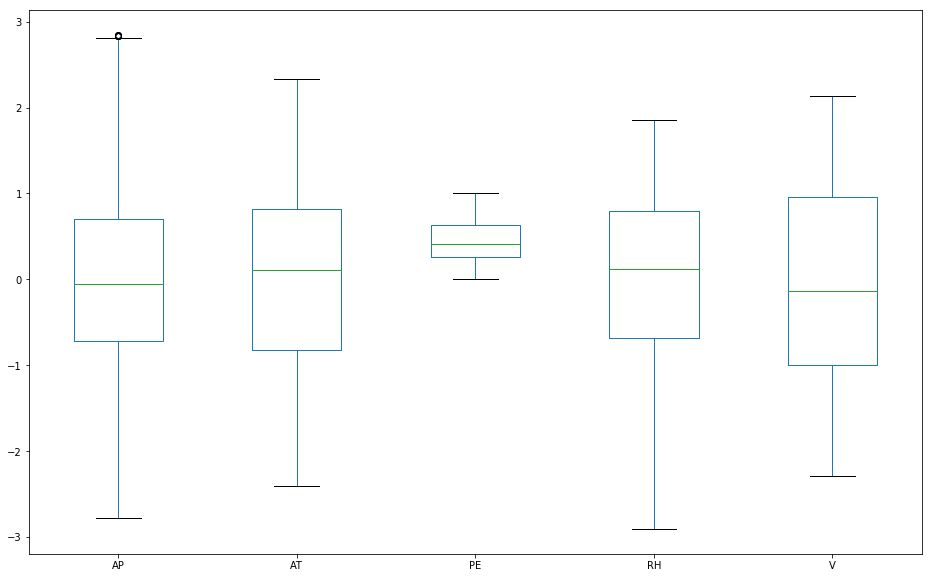

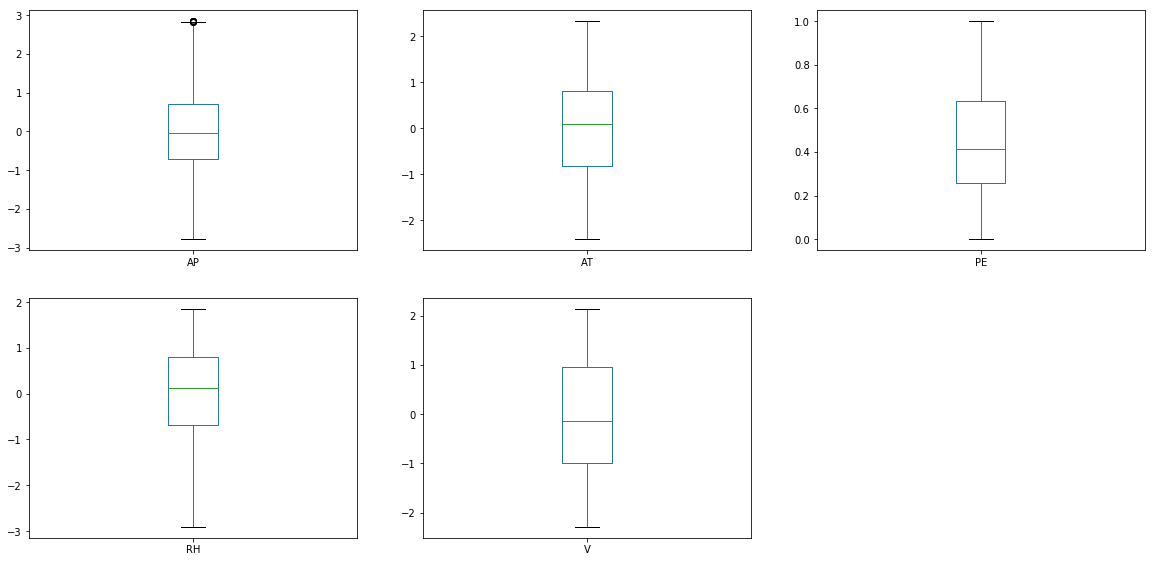

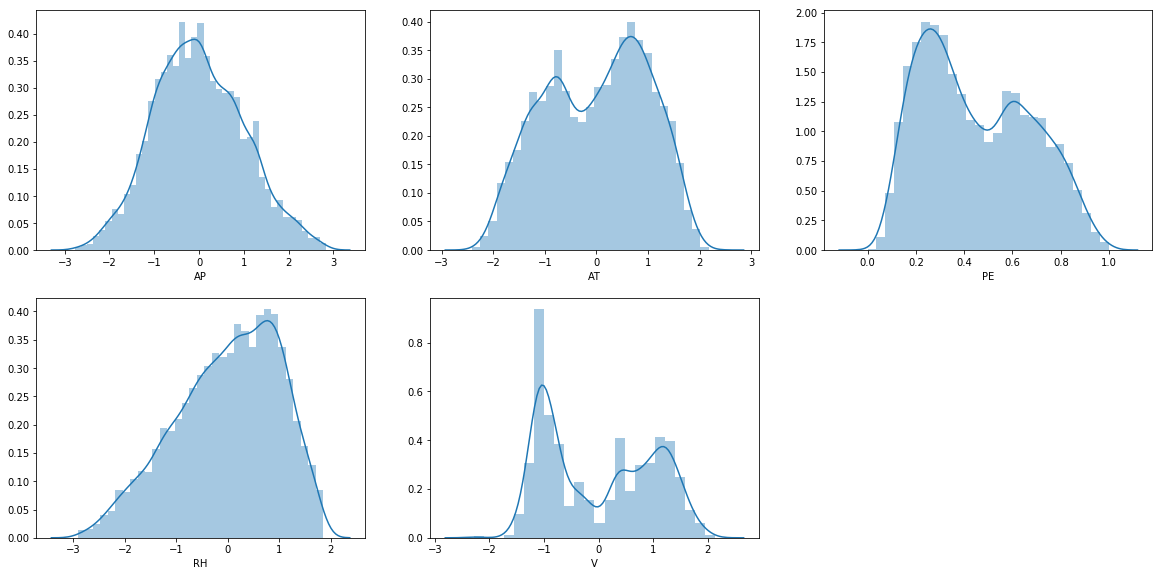

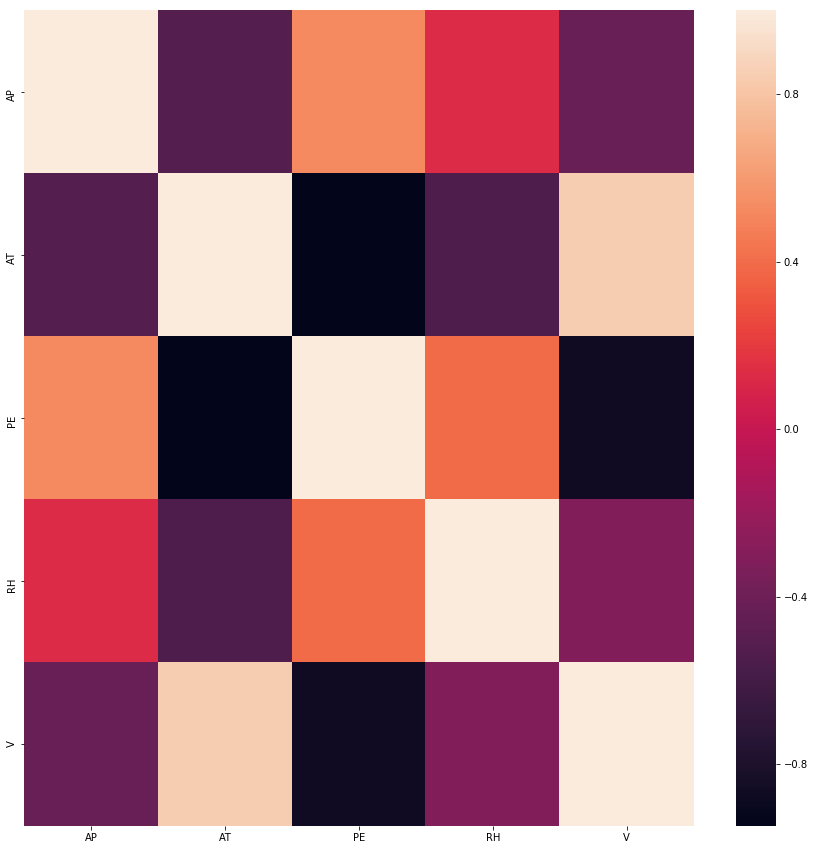

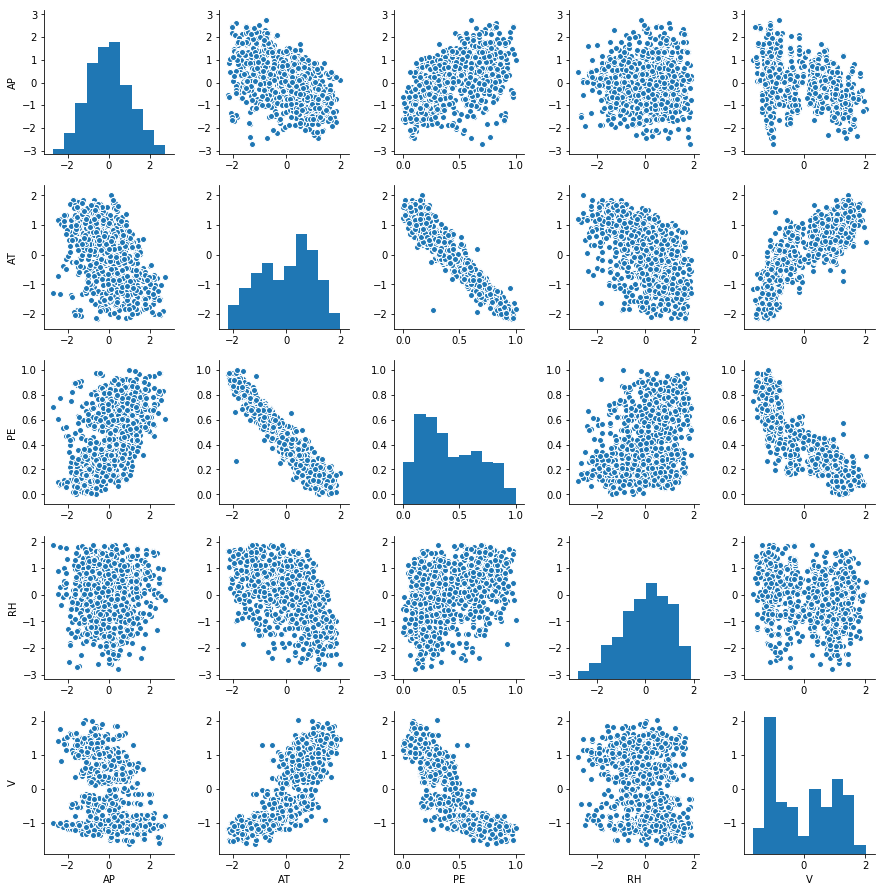

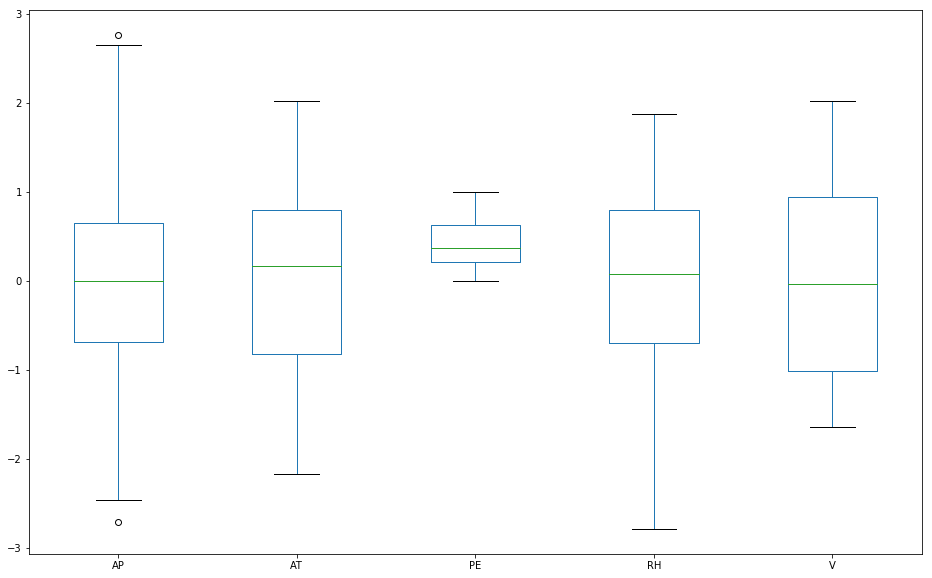

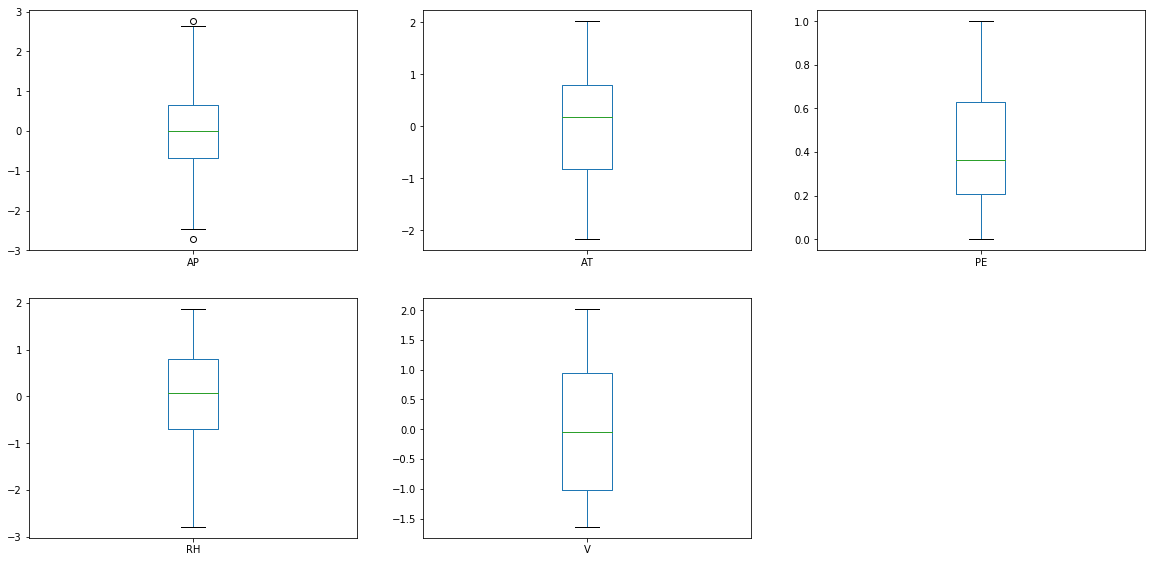

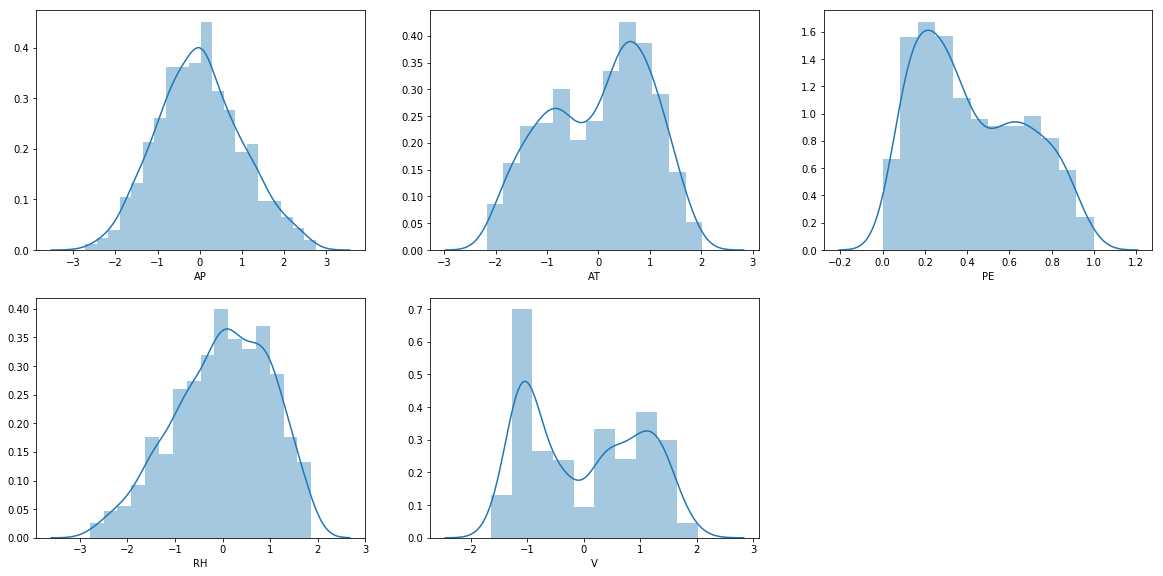

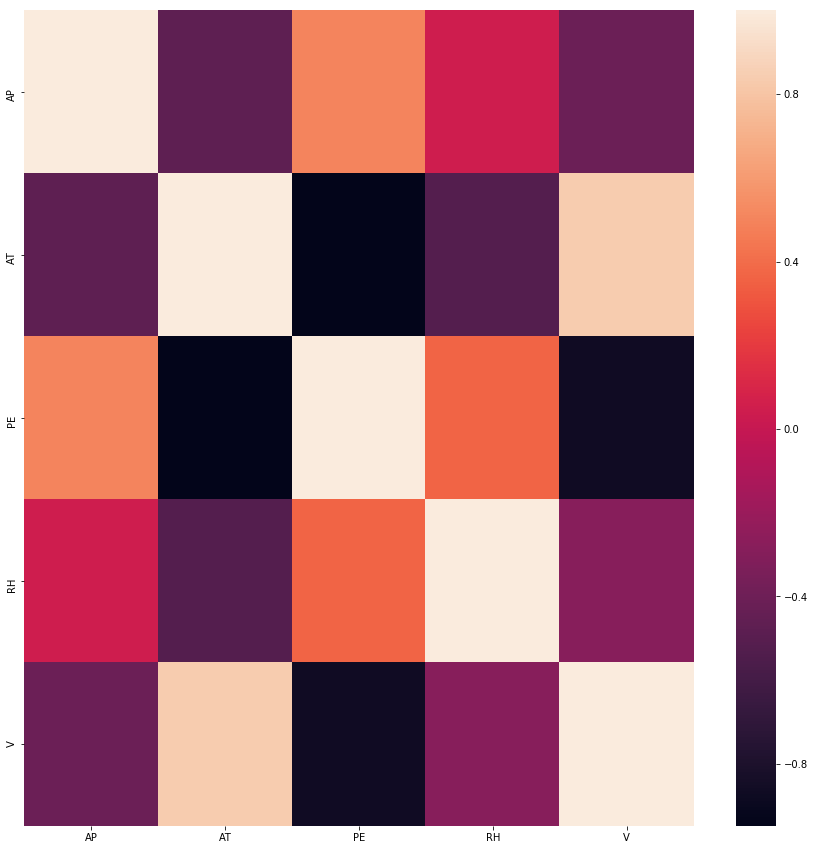

In [56]:
# выходы
feature_list = ['PE']
X= scaling(X, ttype='minmax', feat_list=feature_list, name='new_out_train', a=True)
X_test = scaling(X_test, ttype='minmax', feat_list=feature_list, name='new_out_test', a=True)

In [57]:
X, X_val = train_test_split(X, test_size=1/3, random_state=11)
print(X.shape, X_val.shape, X_test.shape)

(5622, 5) (2812, 5) (938, 5)


In [58]:
get_etr(X)
get_etr(X_val)
get_etr(X_test)

            AP        AT        PE        RH         V
9267 -1.029158  1.336958  0.235497 -0.454642  1.004429
2686 -0.825783  0.367376  0.321060  0.719440 -0.322275
3409 -0.175336  0.512410  0.233907  1.022963  1.477634
8960  2.603532 -1.385124  0.713907  0.816016 -1.024602
981   0.608358 -0.599521  0.509934 -0.562255 -1.134832 

[[ 1.33695848  1.00442921 -1.02915794 -0.45464224]
 [ 0.36737594 -0.322275   -0.82578341  0.71944023]
 [ 0.51241045  1.47763351 -0.17533555  1.02296332]
 [-1.38512434 -1.0246015   2.60353198  0.81601576]
 [-0.59952077 -1.13483212  0.60835769 -0.56225497]]
[0.23549669 0.3210596  0.23390728 0.71390728 0.50993377] 

РЕЗУЛЬТАТЫ:
 ['AT', 'V', 'AP', 'RH'] 
 [0.57207247 0.36524368 0.02409117 0.03859268]
            AP        AT        PE        RH         V
2276 -1.399089  0.523154  0.256954 -0.594677  1.222528
571   0.096415  0.011504  0.575629 -0.965113 -1.182861
5647  0.534722  0.665502  0.452450 -0.767133 -0.329361
3680 -0.820524  1.349045  0.265033 -1.699777  0.

НОВЫЕ ОБУЧ., ВАЛИД. И ТЕСТ

In [59]:
BATCH_SIZE = len(X_data)
IN_SIZE = 4
OUT_SIZE = 1

In [60]:
feat_list = ['AT', 'V', 'AP', 'RH', 'PE']
X[feat_list].to_csv(HOME_DIR+'split_data/train_set.csv', index=False)
X_val[feat_list].to_csv(HOME_DIR+'split_data/val_set.csv', index=False)
X_test[feat_list].to_csv(HOME_DIR+'split_data/test_set.csv', index=False)

In [61]:
X[feat_list].head()

,AT,V,AP,RH,PE
9267,1.336958,1.004429,-1.029158,-0.454642,0.235497
2686,0.367376,-0.322275,-0.825783,0.719440,0.321060
3409,0.512410,1.477634,-0.175336,1.022963,0.233907
8960,-1.385124,-1.024602,2.603532,0.816016,0.713907
981,-0.599521,-1.134832,0.608358,-0.562255,0.509934


In [62]:
np.sort(X['PE'])

array([0.06423841, 0.06463576, 0.06463576, ..., 0.99311258, 0.99456954,
       1.        ])

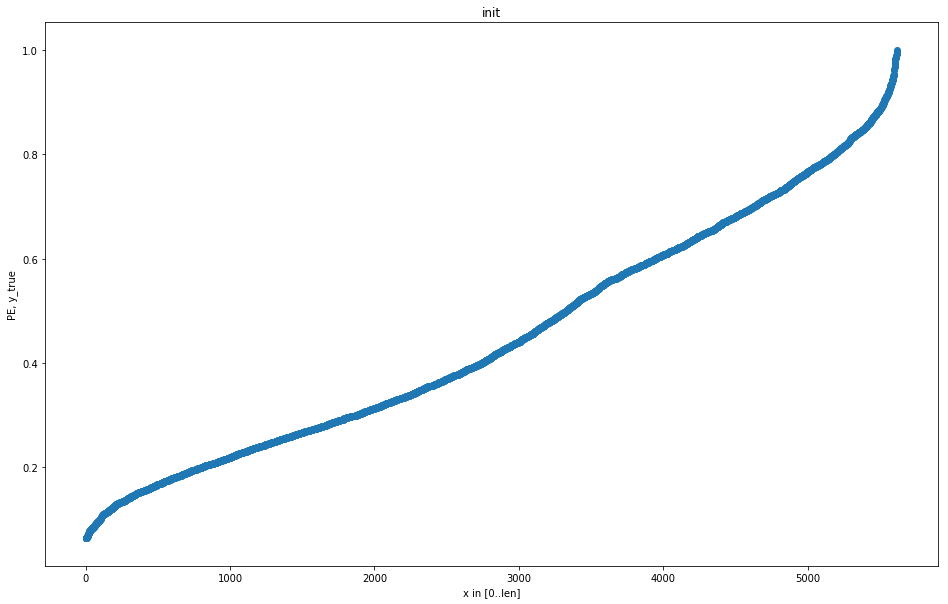

In [63]:
fig = plt.figure(figsize=(16 ,10))
plt.scatter([x for x in range(len(X['PE']))], np.sort(X['PE']))
plt.title('init')
plt.xlabel('x in [0..len]')
plt.ylabel('PE, y_true')
plt.savefig(RES_DIR+'pred_true/init.png')

--------------------------------------------------------------------

ДИЧЬ

In [5]:
def save_wts(net, save_dir, before=False, is_pytorch=False):
    if is_pytorch:
        net_wts = copy.deepcopy(net.state_dict())
        if before:
            torch.save(net_wts, save_dir+'params_before')
        else:
            torch.save(net_wts, save_dir+'params')
    else:
        !!! #ЧТО_ТО ИЗ ЭТОГО ТРАНСПОНИРУЕТСЯ
        w1 = pd.DataFrame((net.lin1.W).data.numpy())
        b1 = pd.DataFrame((net.lin1.b).data.numpy())
        w2 = pd.DataFrame((net.lin2.W).data.numpy())
        b2 = pd.DataFrame((net.lin2.b).data.numpy())
        w3 = pd.DataFrame((net.lin3.W).data.numpy())
        b3 = pd.DataFrame((net.lin3.b).data.numpy())
        w4 = pd.DataFrame((net.lin4.W).data.numpy())
        b4 = pd.DataFrame((net.lin4.b).data.numpy())
        if before:
            w1.to_csv(save_dir+'w1_before.csv', index=False)
            w2.to_csv(save_dir+'w2_before.csv', index=False)
            w3.to_csv(save_dir+'w3_before.csv', index=False)
            w4.to_csv(save_dir+'w4_before.csv', index=False)
            b1.to_csv(save_dir+'b1_before.csv', index=False)
            b2.to_csv(save_dir+'b2_before.csv', index=False)
            b3.to_csv(save_dir+'b3_before.csv', index=False)
            b4.to_csv(save_dir+'b4_before.csv', index=False)
        else:
            w1.to_csv(save_dir+'w1_.csv', index=False)
            w2.to_csv(save_dir+'w2_.csv', index=False)
            w3.to_csv(save_dir+'w3_.csv', index=False)
            w4.to_csv(save_dir+'w4_.csv', index=False)
            b1.to_csv(save_dir+'b1_.csv', index=False)
            b2.to_csv(save_dir+'b2_.csv', index=False)
            b3.to_csv(save_dir+'b3_.csv', index=False)
            b4.to_csv(save_dir+'b4_.csv', index=False)
            
def load_wts(net, load_dir, before=False, is_pytorch=False):  
    path = load_dir
    if before:
        if is_pytorch:
            net.load_state_dict(torch.load(load_dir+'params_before'))
        else:
            net.lin1.W = Parameter(torch.FloatTensor(pd.read_csv(path+'w1_before.csv', sep=',').values))
            net.lin2.W = Parameter(torch.FloatTensor(pd.read_csv(path+'w2_before.csv', sep=',').values))
            net.lin1.b = Parameter(torch.FloatTensor(pd.read_csv(path+'b1_before.csv', sep=',').values).squeeze())
            net.lin2.b = Parameter(torch.FloatTensor(pd.read_csv(path+'b2_before.csv', sep=',').values).squeeze())
            net.lin3.W = Parameter(torch.FloatTensor(pd.read_csv(path+'w3_before.csv', sep=',').values))
            net.lin4.W = Parameter(torch.FloatTensor(pd.read_csv(path+'w4_before.csv', sep=',').values))
            net.lin3.b = Parameter(torch.FloatTensor(pd.read_csv(path+'b3_before.csv', sep=',').values).squeeze())
            net.lin4.b = Parameter(torch.FloatTensor(pd.read_csv(path+'b4_before.csv', sep=',').values).squeeze())
    else:
        if is_pytorch:
            net.load_state_dict(torch.load(load_dir+'params'))
        else:
            net.lin1.W = Parameter(torch.FloatTensor(pd.read_csv(path+'w1_.csv', sep=',').values))
            net.lin2.W = Parameter(torch.FloatTensor(pd.read_csv(path+'w2_.csv', sep=',').values))
            net.lin1.b = Parameter(torch.FloatTensor(pd.read_csv(path+'b1_.csv', sep=',').values).squeeze())
            net.lin2.b = Parameter(torch.FloatTensor(pd.read_csv(path+'b2_.csv', sep=',').values).squeeze())
            net.lin3.W = Parameter(torch.FloatTensor(pd.read_csv(path+'w3_.csv', sep=',').values))
            net.lin4.W = Parameter(torch.FloatTensor(pd.read_csv(path+'w4_.csv', sep=',').values))
            net.lin3.b = Parameter(torch.FloatTensor(pd.read_csv(path+'b3_.csv', sep=',').values).squeeze())
            net.lin4.b = Parameter(torch.FloatTensor(pd.read_csv(path+'b4_.csv', sep=',').values).squeeze())
    return net

Для PyTorch

In [ ]:
# начальная точка длля всех моделей pytorch
net = MainPyNet(IN_SIZE, OUT_SIZE)
print(net)

first = True
if first:
    save_wts(net, HOME_DIR+'split_data/', before=True, is_pytorch=True)  

In [14]:
class CCPPDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
datasets = {x: CCPPDataset(pd.read_csv(HOME_DIR+'split_data/'+x+'_set.csv').values)
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}

In [ ]:
dataset = CCPPDataset(train_data)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
from IPython import display

# обучение модели; dataloader разделен на обуч. и валид. выборки
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25, need_wts=False):
    since = time.time()

    err_epoh = []
    valid_err_epoh = []
    test_err_epoh = []
    wts_list = []
    for i in range(8):
        wts_list.append([])

    for epoch in range(num_epochs):
        if (epoch%50 == 1):
            plt.grid(True)
            plt.plot(err_epoh, color='r')
            plt.plot(valid_err_epoh, color='b')
            plt.plot(test_err_epoh, color='g')
            
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print("train: ", loss_epoh[epoh-1])
            print("valid: ", valid_loss_epoh[epoh-1])
            print("test: ", test_loss_epoh[epoh-1])
            print('-' * 10)          
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0                
            
            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda(CUDA_DEVICE))
                    labels = Variable(labels.cuda(CUDA_DEVICE))
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]
            
            # для графиков E(t)
            if phase == 'train':
                err_epoh.append(epoch_loss)
            elif phase == 'val':
                valid_err_epoh.append(epoch_loss)
            else:
                test_err_epoh.append(epoch_loss)
                
            # для графиков w(t)
            if need_wts:
                wts_list[0].append(model.fc1.weight[0,2])
                wts_list[1].append(model.fc1.weight[8,1])
                wts_list[2].append(model.fc2.weight[2,3])
                wts_list[3].append(model.fc2.weight[8,8])
                wts_list[4].append(model.fc3.weight[4,7])
                wts_list[5].append(model.fc3.weight[2,0])
                wts_list[6].append(model.fc4.weight[0])
                wts_list[7].append(model.fc4.weight[2])
            
            if (epoch%50 == 1):
                print('{} Loss: {:.4f}'.format(phase, epoch_loss))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return model, wts_list, err_epoh, valid_err_epoh, test_err_epoh

In [ ]:
# генерация весов; in_size, out_size=width для W
# типы распр-й:
# u=uniform, n=normal, cn=cut-normal(усеченное нормальное)
def generate_weight(in_size, out_size, p_type, sigma):
    W, b = None
    if (p_type == 'u'):
        W = Parameter(sigma * torch.randn((out_size, in_size)))
        b = Parameter(sigma * torch.randn(out_size))
    elif(p_type == 'n'):
        W = Parameter(torch.FloatTensor(out_size, in_size).normal_(mean=0, std=sigma))
        b = Parameter(torch.FloatTensor(out_size).normal_(mean=0, std=sigma))
    else:
        W = 
        b = 
    return W, b

In [4]:
# тест
def get_prediction(outputs):
    val, idx = torch.max(outputs, dim=1)
    return idx.data.cpu().view(-1)

def get_acc(preds, targets):
    return np.sum(preds==targets)/len(targets)

# выход: лосс, список предсказанных моделью значений
def test_model(net, loader, criterion):
    net.eval()
    
    test_loss = 0.
    count = 0
    y_hat = []
    
    for data, target in loader:
        count += 1
        
        if use_gpu:
            data = Variable(data.cuda(CUDA_DEVICE), volatile=True)
            target = Variable(target.cuda(CUDA_DEVICE))
        else:       
            data = Variable(data, volatile=True)
            target = Variable(target)
        
        output = net(data)
        test_loss += criterion(output, target).data[0]
        pred = (get_prediction(output)).numpy()
        y_hat.extend(pred)
        test_acc += get_acc(pred, target.data.cpu().numpy())
        if (count%10 == 0):
            print(count*len(data), end=" ")
            print(test_loss/(count*len(data)))
        
    test_loss /= len(loader)
    
    return test_loss, y_hat

In [21]:
in_size = 4
out_size = 1

net = MyNet(in_size, out_size)
print(net)

a = False
if a:
    model_wts = copy.deepcopy(net.state_dict())
    torch.save(model_wts, HOME_DIR+'split_data/mynet_params')

MyNet(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=1, bias=True)
)